In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame([], columns=['a', 'b'])

In [3]:
df

,a,b


In [4]:
df.loc[0] = [1, 2]
df.loc[1] = [3, 4]

In [8]:
for x in df.itertuples():
    print(type(x))
    print(x)

<class 'pandas.core.frame.Pandas'>
Pandas(Index=0, a=1, b=2)
<class 'pandas.core.frame.Pandas'>
Pandas(Index=1, a=3, b=4)


In [2]:
import numpy as np

x = ["a", "a", "b", "a", "c"]
print(np.unique(x, return_inverse=True))

(array(['a', 'b', 'c'], dtype='<U1'), array([0, 0, 1, 0, 2], dtype=int64))


In [1]:
import pickle
import numpy as np
from hyperopt import Trials
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

with open("rand_trials_200.bin", "rb") as f:
    trials = pickle.load(f)

In [2]:
losses = - np.array(trials.losses())

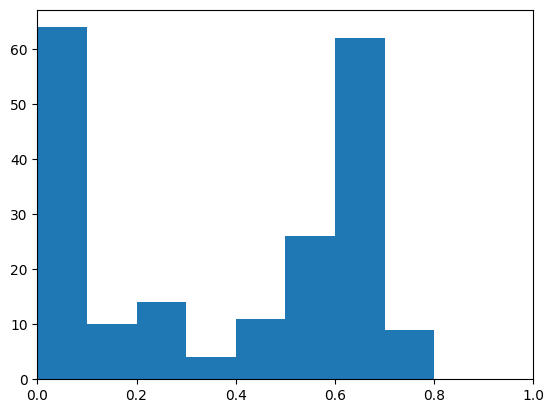

In [3]:
plt.xlim(0, 1)
plt.hist(losses // 0.1 * 0.1, bins=[0.1 * i for i in range(11)])
plt.savefig("hist_rand_200.png")

<BarContainer object of 200 artists>

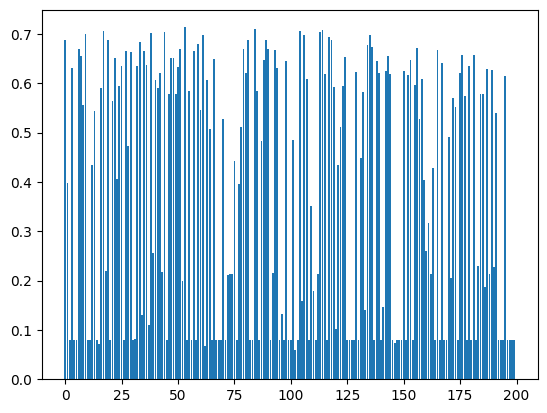

In [4]:
plt.bar(np.arange(len(losses)), losses)

In [5]:
regression = LinearRegression()
regression.fit(np.arange(len(losses)).reshape(-1, 1), losses)
print(f'{round(regression.coef_[0] * 100, 3)}%')
print(regression.intercept_)
print(np.mean(losses))

-0.056%
0.4424510687846232
0.3871375349426691


In [35]:
import math

In [40]:
6.336724645751509 * math.exp(-6)

0.015707170008591915

In [56]:
import numpy as np
import pandas as pd
import torch
import math
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
from hyperopt import STATUS_OK

from process_data import clean_data, get_filtered_corpus, to_categorical, TF_IDF_Dataset
from tf_idf import preprocess_tf_idf
from mlp import MLP
import nlpaug.augmenter.word as nlpaw
from data_augmentation import augment_text
import os
import json

from time import time
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
torch.manual_seed(42)
np.random.seed(42)
test_size = 0.2

df = pd.read_csv("data.csv")[["summary", "genre"]]
df = df.drop_duplicates(subset=["summary"], keep="first").reset_index(drop=True)

test_df = df.sample(frac=test_size, random_state=42)
train_df = df.drop(test_df.index).reset_index(drop=True)
data_length = len(train_df)

# We then proceed with the cleaning process
print("Cleaning data...")
train_corpus, train_vocab = clean_data(train_df["summary"])
test_corpus, test_vocab = clean_data(test_df["summary"])

# This line gets all the frequencies of each word and sorts it in descending order
train_frequencies = sorted(train_vocab.items(), key=lambda x: x[1], reverse=True)
test_frequencies = sorted(test_vocab.items(), key=lambda x: x[1], reverse=True)

# We choose to only consider the first 15000 most common non-stop words
vocab_size = 15000
# Convert back to dictionary
train_vocab = {x[0]: x[1] for x in train_frequencies[:vocab_size]}
test_vocab = {x[0]: x[1] for x in test_frequencies[:vocab_size]}

train_corpus = get_filtered_corpus(train_corpus, train_vocab.keys())
test_corpus = get_filtered_corpus(test_corpus, test_vocab.keys())
print("Data cleaned!")

Cleaning data...
Data cleaned!


In [88]:
train_vocab.update(test_vocab)

In [87]:
len(train_vocab)

19677

In [67]:
# Get the keys from all dictionaries in list1
keys_list1 = set().union(*[d.keys() for d in test_corpus])

# Get the keys from all dictionaries in list2
keys_list2 = set().union(*[d.keys() for d in train_corpus])

# Find the intersection of the keys
common_keys = keys_list1.intersection(keys_list2)

print(common_keys)  # Output: {'c'}

{'unexplained', 'feast', 'inhabited', 'joined', 'nick', 'decent', 'due', 'flees', 'consumes', 'held', 'provided', 'removes', 'burden', 'eager', 'crispin', 'un', 'pressing', 'witchcraft', 'unbearable', 'fueled', 'handful', 'florence', 'working', 'master', 'spike', 'spine', 'entrusted', 'unnoticed', 'restores', 'recognizes', 'wreckage', 'engaged', 'shoots', 'toddler', 'floating', 'nothing', 'courier', 'circus', 'frame', 'supposed', 'arms', 'lieutenant', 'taltos', 'stations', 'pair', 'journalism', 'rendezvous', 'seventeenth', 'patriarch', 'mistaking', 'devises', 'vintage', 'ordering', 'slipped', 'julius', 'fielding', 'noticed', 'negotiation', 'vibrant', 'impending', 'suburb', 'doubts', 'traveled', 'shady', 'barry', 'cocktail', 'carol', 'regardless', 'turkish', 'plum', 'populace', 'obi', 'rural', 'commission', 'resist', 'selves', "i'l", 'voyage', 'dimension', 'carrying', 'terrorists', 'teddy', 'language', 'wheelchair', 'boxer', "thorn's", 'battered', 'mate', 'ruthless', 'unidentified', 'en

In [92]:
 # Get the unique genre labels in a sorted order
unique_genres = df["genre"].unique()
unique_genres.sort()

# Create a mapping between genre labels and category indices
genre_to_category = {genre: i for i, genre in enumerate(unique_genres)}

# Perform one-hot encoding using the genre-to-category mapping
train_categorical_genres = to_categorical(train_df["genre"].map(genre_to_category))
test_categorical_genres = to_categorical(test_df["genre"].map(genre_to_category))

In [93]:
genre_to_category

{'crime': 0,
 'fantasy': 1,
 'history': 2,
 'horror': 3,
 'psychology': 4,
 'romance': 5,
 'science': 6,
 'sports': 7,
 'thriller': 8,
 'travel': 9}

In [94]:
test_df

,summary,genre
1647,The story is told in switching first-person n...,history
1476,A skeleton has been unearthed. Soon the body ...,crime
2111,"The widow Mildred Finster has been a fan of ""...",horror
3610,The rugged men of the Carolina Cold Fury hocke...,sports
691,"Uldir, a classmate of Anakin Solo's at the Je...",science
...,...,...
1705,The Winthrop Woman begins with young Elizabet...,history
3273,From the New York Times bestselling author of ...,psychology
4509,Ilona Andrews invites you to experience the fi...,fantasy
2517,"At the beginning of the book, Bourne is in Do...",thriller


In [107]:
train_df["genre"].value_counts()

genre
thriller      802
fantasy       661
science       505
history       485
horror        481
crime         385
romance        90
psychology     80
travel         79
sports         66
Name: count, dtype: int64

In [106]:
test_df["genre"].value_counts()

genre
fantasy       190
thriller      178
science       120
horror        119
crime         115
history       113
romance        21
psychology     19
travel         19
sports         14
Name: count, dtype: int64

In [97]:
test_categorical_genres

array([2, 0, 3, 7, 6, 8, 2, 4, 1, 3, 6, 2, 3, 0, 0, 8, 6, 8, 8, 0, 2, 3,
       6, 3, 1, 3, 1, 8, 2, 7, 3, 1, 8, 1, 1, 8, 2, 1, 7, 0, 9, 5, 1, 9,
       0, 1, 3, 4, 8, 1, 5, 0, 2, 3, 0, 8, 0, 4, 1, 2, 1, 6, 8, 2, 1, 1,
       1, 5, 8, 1, 1, 3, 8, 6, 3, 2, 1, 2, 0, 3, 6, 6, 3, 6, 2, 8, 3, 6,
       0, 1, 9, 8, 1, 2, 8, 8, 2, 1, 8, 0, 8, 0, 5, 3, 0, 8, 1, 8, 2, 2,
       6, 8, 1, 2, 1, 1, 8, 0, 0, 1, 8, 3, 5, 1, 6, 6, 0, 8, 1, 2, 1, 1,
       9, 8, 1, 8, 2, 2, 4, 6, 9, 2, 3, 9, 3, 2, 0, 2, 0, 1, 6, 0, 3, 8,
       6, 6, 8, 0, 0, 6, 8, 6, 1, 2, 3, 6, 5, 1, 0, 1, 2, 8, 8, 6, 6, 3,
       2, 2, 2, 8, 0, 1, 3, 3, 6, 8, 0, 3, 0, 8, 0, 1, 0, 3, 6, 8, 8, 2,
       8, 1, 9, 0, 8, 3, 1, 2, 8, 8, 8, 8, 1, 8, 6, 2, 1, 0, 1, 8, 9, 1,
       8, 3, 1, 2, 0, 8, 0, 1, 3, 3, 3, 0, 8, 8, 3, 1, 4, 6, 6, 8, 1, 0,
       2, 3, 6, 1, 3, 3, 6, 2, 0, 6, 1, 3, 0, 6, 1, 0, 1, 6, 8, 1, 6, 0,
       8, 1, 0, 8, 0, 2, 3, 0, 2, 6, 1, 6, 0, 3, 1, 2, 5, 3, 8, 0, 2, 5,
       7, 3, 0, 6, 0, 3, 6, 6, 8, 6, 3, 2, 1, 6, 8,

In [95]:
train_df

,summary,genre
0,Drowned Wednesday is the first Trustee among ...,fantasy
1,"As the book opens, Jason awakens on a school ...",fantasy
2,Cugel is easily persuaded by the merchant Fia...,fantasy
3,The book opens with Herald-Mage Vanyel return...,fantasy
4,Taran and Gurgi have returned to Caer Dallben...,fantasy
...,...,...
3629,"Also Known As: Two Pearls of Wisdom, Eon: Rise...",fantasy
3630,This is the extraordinary love story of Clare ...,fantasy
3631,A strange imprisonment...\r\n\r\nBeauty has ne...,fantasy
3632,J.K. Rowling's screenwriting debut is captured...,fantasy


In [96]:
train_categorical_genres

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [98]:
df = pd.read_csv("data.csv")[["summary", "genre"]]
dropped_df = df.drop_duplicates(subset=["summary"], keep="first").reset_index(drop=True)

In [99]:
len(df)

4657

In [108]:
len(train_df)

3634